# Imports

In [40]:
# Hiding tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [41]:
# Python Imports
import os
import shutil
import random
import glob
import itertools

# Third-party Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report

# Data processing

In [42]:
home_dir = os.path.expanduser('~')
project_dir = f'{home_dir}/Projects/fire'

In [43]:
# changing into dataset directory
os.chdir(f'{project_dir}/data/fire-vs-without-fire')

In [44]:
# organize data into train, valid, test dirs
if os.path.isdir('train/with_fire') is False:
    
    labels = ['with_fire', 'without_fire']
    folders = ['train', 'valid', 'test']
    amounts = [850, 50, 50]
    
    for label in labels:
        for folder, amount in zip(folders, amounts):
            # create new folder for the separate data
            os.makedirs(f'{folder}/{label}')
            
            # random select entries
            for c in random.sample(os.listdir(label), amount):
                shutil.move(f'{label}/{c}', f'{folder}/{label}')
        
        # remove original folder
        os.rmdir(label)

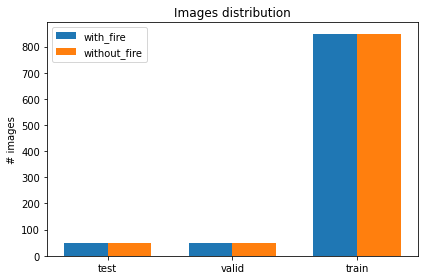

In [45]:
labels = ['with_fire', 'without_fire']
datasets = []
with_mask = []
without_mask = []

for folder_name in os.listdir():
    path = os.path.join(project_dir, 'data', 'fire-vs-without-fire', folder_name)
    
    datasets.append(folder_name)
    
    for children_name in os.listdir(path):
        child_path = os.path.join(path, children_name)
        if children_name == labels[0]:
            with_mask.append(len(os.listdir(child_path)))
        else:
            without_mask.append(len(os.listdir(child_path)))
            
x = np.arange(len(datasets))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, with_mask, width, label=labels[0])
rects2 = ax.bar(x + width/2, without_mask, width, label=labels[1])

ax.set_ylabel('# images')
ax.set_title('Images distribution')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

fig.tight_layout()
plt.show()

In [46]:
# going back to root directory
os.chdir(project_dir)

In [47]:
train_path = f'{project_dir}/data/fire-vs-without-fire/train'
valid_path = f'{project_dir}/data/fire-vs-without-fire/valid'
test_path = f'{project_dir}/data/fire-vs-without-fire/test'

In [48]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), classes=['with_fire', 'without_fire'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['with_fire', 'without_fire'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), classes=['with_fire', 'without_fire'], batch_size=10, shuffle=False)

Found 1700 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [49]:
# This function will plot images in the form of a grid with 1 row and 10 columns where 
# images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [50]:
img, labels = next(train_batches)  # gets a single batch of imgs and labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


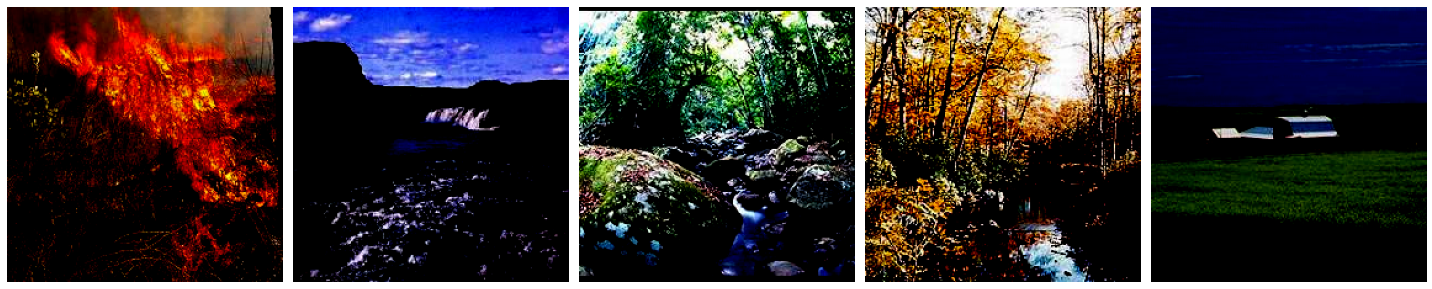

In [51]:
plotImages(img)

## Importing VGG16 model

In [52]:
# include_top=False will return the model without the dense layers, 
# in order to let you make your own dense layers and make your 
# own classification to suit your needs.

mobilenet_base =\
    tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [53]:
mobilenet_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [54]:
model = Sequential()
model.add(mobilenet_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


# Train the fine-tuned VGG16 model

In [56]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
n_epochs = 15

history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=n_epochs,
          verbose=1
)

Epoch 1/15
170/170 [==============================] - 41s 230ms/step - loss: 0.1283 - accuracy: 0.9547 - val_loss: 0.0160 - val_accuracy: 1.0000
Epoch 2/15
170/170 [==============================] - 39s 227ms/step - loss: 0.0573 - accuracy: 0.9753 - val_loss: 0.0353 - val_accuracy: 0.9800
Epoch 3/15
170/170 [==============================] - 41s 240ms/step - loss: 0.0441 - accuracy: 0.9853 - val_loss: 0.0167 - val_accuracy: 0.9900
Epoch 4/15
170/170 [==============================] - 40s 237ms/step - loss: 0.0371 - accuracy: 0.9900 - val_loss: 0.1933 - val_accuracy: 0.9200
Epoch 5/15
170/170 [==============================] - 40s 233ms/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 0.0908 - val_accuracy: 0.9400
Epoch 6/15
170/170 [==============================] - 40s 234ms/step - loss: 0.0080 - accuracy: 0.9982 - val_loss: 9.9834e-04 - val_accuracy: 1.0000
Epoch 7/15
170/170 [==============================] - 41s 241ms/step - loss: 0.0039 - accuracy: 0.9994 - val_loss: 7.5444e-04 

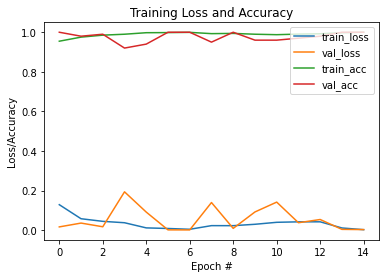

In [58]:
plt.figure()
plt.plot(np.arange(0, n_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

# Convert Model to tflite

In [59]:
model.save('models/model_mobilenet.h5', save_format='h5')

In [60]:
keras_model = tf.keras.models.load_model('models/model_mobilenet.h5')

In [61]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

with open('models/model_mobilenet_lite.tflite', 'wb') as f:
      f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgg0jf58x/assets


INFO:tensorflow:Assets written to: /tmp/tmpgg0jf58x/assets
2022-05-28 08:54:50.792710: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-05-28 08:54:50.792808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-05-28 08:54:50.793682: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpgg0jf58x
2022-05-28 08:54:50.820812: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-05-28 08:54:50.820886: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpgg0jf58x
2022-05-28 08:54:50.903162: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-05-28 08:54:50.935207: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-28 08:54:51.700681: I tensorflow/cc/saved_model/loader.cc:212] Running initializatio

# Predict using fine-tuned VGG16 model

In [62]:
predictions = model.predict(x=test_batches, verbose=0)

In [63]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization


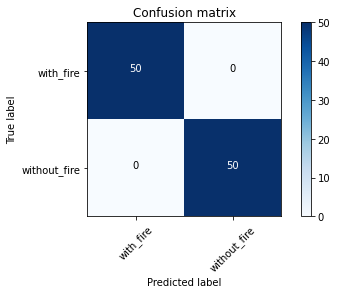

In [65]:
cm_plot_labels = ['with_fire', 'without_fire']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

In [66]:
# Classification report
print(classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [67]:
batch_size = 10
pred_labels = np.argmax(predictions, axis=-1)
index = 0

mislabeled_images = []
mislabeled_labels = []
true_labels = []

for i in range(0, len(test_batches)):
    img, labels = next(test_batches)
    labels = np.argmax(labels, axis=-1)
    
    predicted_labels = pred_labels[index:(index + batch_size)]
    
    corrected_predicted = (labels == predicted_labels)
    mislabeled_indices = np.where(corrected_predicted == 0)[0]
        
    if(len(mislabeled_indices) != 0):        
        mislabeled_images += [img for img in img[mislabeled_indices]]
        mislabeled_labels += [label for label in predicted_labels[mislabeled_indices]]
        true_labels += [label for label in labels[mislabeled_indices]]
        
    index += batch_size

In [68]:
def display_examples(class_names, mislabeled_images, mislabeled_labels, true_labels):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Some images that where incorrected predicted", fontsize=16, x= 0.5, y=0.98)
    for i in range(len(mislabeled_images)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel('prediction: {}\n label: {}'.format(class_names[mislabeled_labels[i]], class_names[true_labels[i]]))
    plt.show()

In [69]:
display_examples(['with_fire', 'without_fire'], mislabeled_images[:5], mislabeled_labels[:5], true_labels[:5])

<Figure size 720x720 with 0 Axes>